In [253]:
#|default_exp augment

In [254]:
#|export
import torch
import random

import fastcore.all as fc
from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [255]:
import pickle, math, gzip, os, time, shutil
import matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

In [256]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor, optim
from torch.utils.data import DataLoader, default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

In [257]:
from torch import distributions

In [258]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [259]:
import logging
logging.disable(logging.WARNING)

set_seed(1)

In [260]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
bs = 1024
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
    
dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [261]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [262]:
set_seed(1)
lr = 6e-2
epochs = 5

### Deeper/wider resnet

The first thing we can do to improve the accuracy of our resnet is to have more channels.

In [263]:
def get_model0(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [264]:
set_seed(1)

In [18]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model0(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.822,0.712,0,train
0.842,0.528,0,eval
0.900,0.376,1,train
0.869,0.407,1,eval
0.923,0.259,2,train
0.913,0.271,2,eval
0.945,0.187,3,train
0.927,0.236,3,eval
0.967,0.130,4,train
0.933,0.220,4,eval


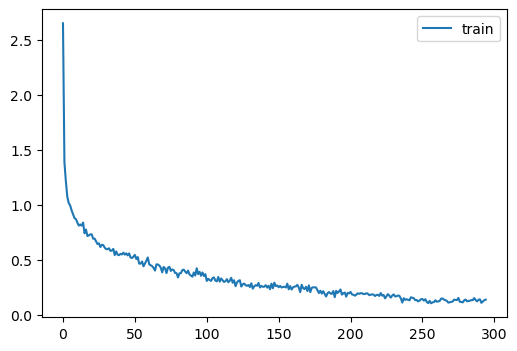

In [19]:
learn.fit(epochs)

If we try to increase the kernel size of the first layer to `5x5`:

In [12]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [13]:
set_seed(1)

In [67]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.830,0.695,0,train
0.846,0.514,0,eval
0.896,0.386,1,train
0.897,0.335,1,eval
0.921,0.265,2,train
0.911,0.280,2,eval
0.944,0.191,3,train
0.916,0.256,3,eval
0.964,0.137,4,train
0.931,0.225,4,eval


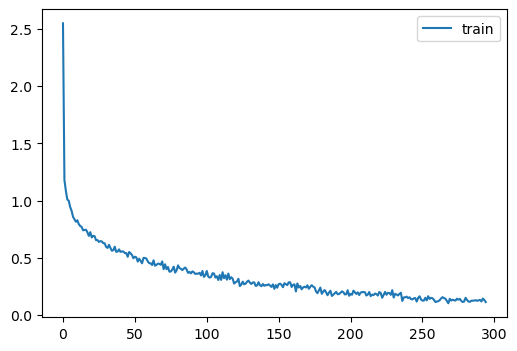

In [68]:
learn.fit(epochs)

The accuracy is not as good with a larger kernel in the first layer. This is a good observation because, as we'll see right now, the number of parameters is a bit smaller by the number of multiplication operation is much larger for a `5x5` kernel.

### Pooling

We note that with the present models we need to insure that the last res block brings the output to a `1x1` image size. In order to make this part of the model more flexible we can add a pooling layer that will change any output `(N,C,k,k)` to `(N,C,1,1)`:

In [14]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

Pytorch has a aversion called `AdaptiveAvgPool2d` that can output any `k,l` size.

In [15]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

The last resblock has a `stride=1` so the height and width dimensions are still `2x2` after that block. The pooling layer converts this `2x2` dim to `1x1`.

We can include the number of multiplications, a sort of proxy for MFLOPS, in the `summary` method:

In [16]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=[SingleBatchCB()])
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [82]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4903236; MFLOPS: 29.6


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|2576|1.9|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


The last ResBlock has by far the largest number of parameters, about 3 times the total of all other resblocks whereas in terms of number of operations(multiplications) the last block is still the heaviest but only represents 0.8 times all the other resblocks.

accuracy,loss,epoch,train
0.820,0.728,0,train
0.831,0.586,0,eval
0.900,0.378,1,train
0.863,0.423,1,eval
0.923,0.259,2,train
0.910,0.274,2,eval
0.944,0.188,3,train
0.923,0.245,3,eval
0.966,0.132,4,train
0.932,0.217,4,eval


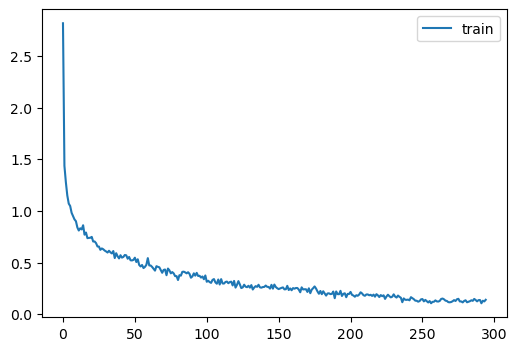

In [83]:
set_seed(1)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Reducing the number of parameters and operations is a good way to optimize on respectively the memory and compute. <br>
Let's see if we can remove the last resblock and keep a similar accuracy:

In [17]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [85]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1227076; MFLOPS: 14.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|2576|1.9|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


The number of parameters and operations dropped rescpectiely by 3/4 and 1/2, let's see if the accuracy holds up: 

In [86]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

accuracy,loss,epoch,train
0.803,0.785,0,train
0.866,0.468,0,eval
0.900,0.389,1,train
0.888,0.414,1,eval
0.923,0.268,2,train
0.909,0.277,2,eval
0.942,0.199,3,train
0.927,0.242,3,eval
0.961,0.148,4,train
0.935,0.222,4,eval


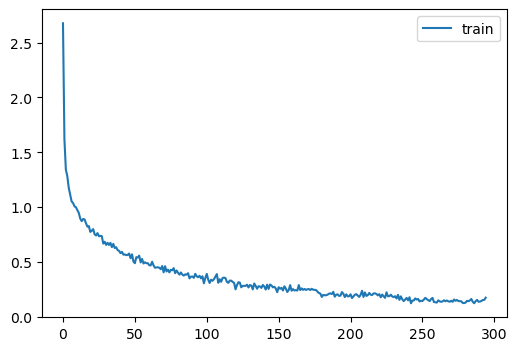

In [88]:
set_seed(1)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

This model is even better! Let's see if we can replace the first `ResBlock` by a simple `Conv2d`:

In [18]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [90]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [91]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224692; MFLOPS: 13.1


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|192|0.1|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.813,0.759,0,train
0.880,0.437,0,eval
0.905,0.375,1,train
0.901,0.331,1,eval
0.927,0.257,2,train
0.913,0.278,2,eval
0.947,0.189,3,train
0.924,0.254,3,eval
0.969,0.132,4,train
0.934,0.226,4,eval


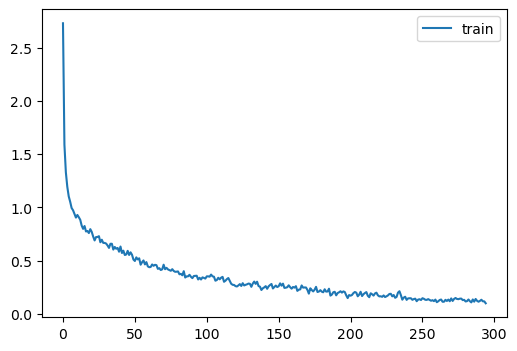

In [92]:
set_seed(1)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Almost as good and better than the Conv net and deeper resnets.

In [19]:
def get_model4_(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=2, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [97]:
TrainLearner(get_model4_(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224612; MFLOPS: 14.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 29, 29)|112|0.1|
|ResBlock|(1024, 16, 29, 29)|(1024, 32, 15, 15)|14560|3.2|
|ResBlock|(1024, 32, 15, 15)|(1024, 64, 8, 8)|57792|3.7|
|ResBlock|(1024, 64, 8, 8)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.804,0.780,0,train
0.846,0.510,0,eval
0.900,0.387,1,train
0.878,0.377,1,eval
0.922,0.266,2,train
0.910,0.285,2,eval
0.944,0.194,3,train
0.924,0.252,3,eval
0.966,0.137,4,train
0.933,0.228,4,eval


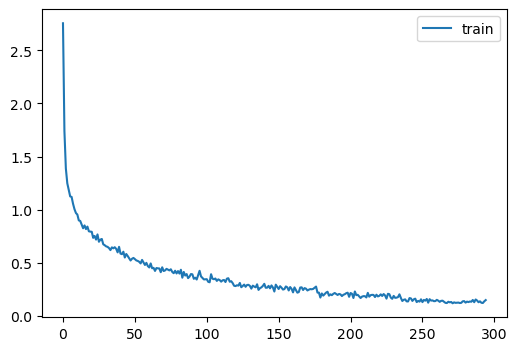

In [99]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

### Train for longer?

In [20]:
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

accuracy,loss,epoch,train
0.784,0.856,0,train
0.854,0.630,0,eval
0.890,0.536,1,train
0.864,0.531,1,eval
0.912,0.405,2,train
0.894,0.402,2,eval
0.922,0.310,3,train
0.907,0.310,3,eval
0.926,0.259,4,train
0.862,0.415,4,eval


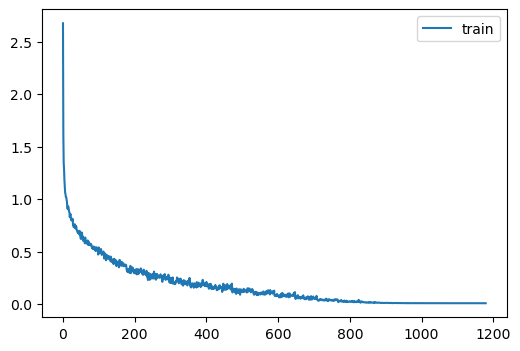

In [152]:
set_seed(1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

If we train for longer the model will see many times the same images and start to overfit. To counter this we can implement data augmentation, each batch will randomly be transformed with a combination of rotation, flip, crop, translation.

In [21]:
from torchvision import transforms

In [22]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip(),
                     transforms.RandomRotation(5))

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [23]:
set_seed(1)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])

In [24]:
learn.fit(1)

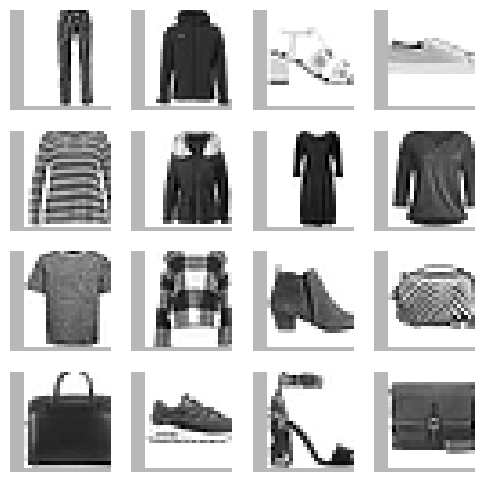

In [25]:
xb, yb = learn.batch
mpl.rcParams['image.cmap'] = 'gray_r'
show_images(xb[:16], imsize=1.5)

In [27]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.766,0.871,0,train
0.828,0.627,0,eval
0.859,0.587,1,train
0.858,0.505,1,eval
0.874,0.479,2,train
0.882,0.384,2,eval
0.883,0.402,3,train
0.872,0.399,3,eval
0.896,0.331,4,train
0.871,0.379,4,eval


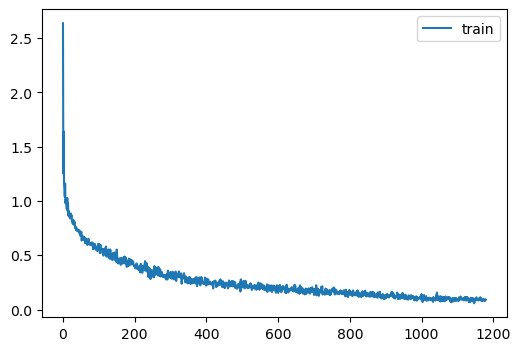

In [30]:
set_seed(1)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

We get 94.4% on the validation set in just 20 epochs, an excellent state-of-the-art result that is on par with the 7th best published model on Fashion-MNIST, see the [ranking](https://paperswithcode.com/sota/image-classification-on-fashion-mnist).

We can try with model_3, the lighter version of our light resnet:

accuracy,loss,epoch,train
0.730,0.986,0,train
0.824,0.676,0,eval
0.850,0.634,1,train
0.866,0.519,1,eval
0.881,0.485,2,train
0.832,0.548,2,eval
0.892,0.390,3,train
0.884,0.339,3,eval
0.901,0.326,4,train
0.893,0.319,4,eval


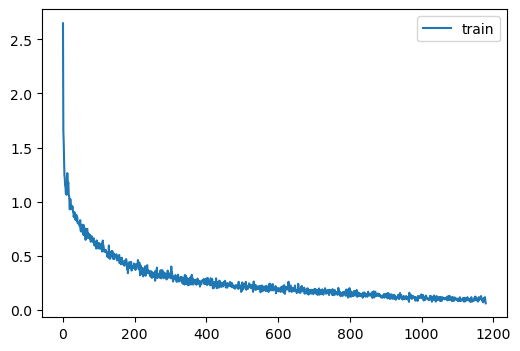

In [31]:
set_seed(1)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Very good, we can try to push the result for another 20 epochs.

In [36]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'model3_data_aug.pkl')

Another 20 epochs:

accuracy,loss,epoch,train
0.964,0.107,0,train
0.939,0.180,0,eval
0.962,0.110,1,train
0.920,0.248,1,eval
0.946,0.154,2,train
0.919,0.242,2,eval
0.937,0.174,3,train
0.897,0.314,3,eval
0.931,0.191,4,train
0.909,0.261,4,eval


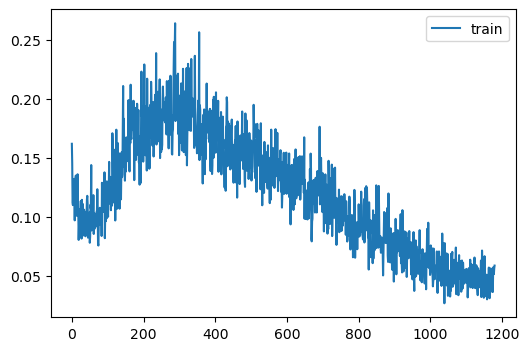

In [38]:
learn.fit(epochs, lr=1e-3)

And now model2:

In [ ]:
set_seed(1)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

-- *added later* --

In [ ]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

### Test Time Augmentation - TTA

We can imprve the model further by going a test time augmentation: On the valid set, we get 2 predictions from the model, one on the validation set and another on the validation set with flipped images. Then we take the average of the predictions.  

In [39]:
#|export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_preds, self.all_targs = [],[]
    def after_batch(self, learn):
        self.all_preds.append(learn.preds)
        self.all_targs.append(learn.batch[1])

In [41]:
cp = CapturePreds()
learn.fit(1, train=False, cbs=[cp])

accuracy,loss,epoch,train
0.946,0.176,0,eval


In [42]:
cp2 = CapturePreds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
learn.fit(1, train=False, cbs=[cp2, ttacb])

accuracy,loss,epoch,train
0.947,0.178,0,eval


In [43]:
ap1 = torch.cat(cp.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp.all_targs)
ap1.shape, ap2.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]))

In [47]:
ap = torch.stack([ap1, ap2]).mean(0).argmax(1)

In [51]:
round((ap==at).float().mean().item(), 3)

0.948

The result is even better, in the thop 6 amongst models that were trained for more than 200 epochs.

-- *improved version* --

In [105]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps. append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn):
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

In [122]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=[], inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+cbs)
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

In [123]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.944,0.164,0,eval


In [124]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

accuracy,loss,epoch,train
0.943,0.168,0,eval


In [125]:
ap1.shape,ap2.shape,at.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]), torch.Size([10000]))

In [126]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [127]:
round((ap==at).float().mean().item(), 3)

0.944

### Random Erase

Random erasing is another regularization startegy that consists of replacing a random square of the image by gaussian noise. It forces the model to never see the complete image and thus build a more robust prediction pattern.

In [54]:
mpl.rcParams['image.cmap'] = 'gray_r'

We need to be careful when generating noise because each image has its own distribtion and min and max values. The clamp at the end of the function ensures that the image keeps the same min/max. 

In [55]:
#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

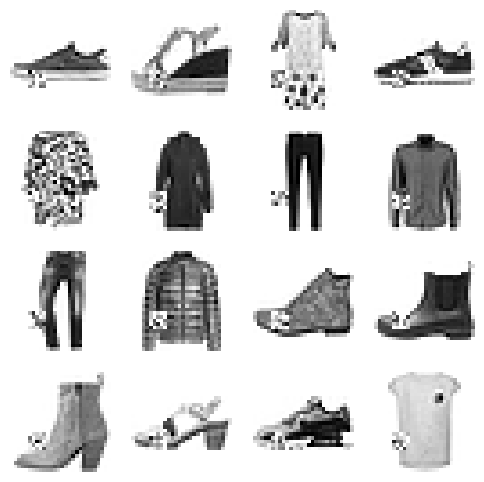

In [56]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [57]:
xbt.mean(),xbt.std(),xbt.min(), xbt.max()

(tensor(-0.17), tensor(0.88), tensor(-0.80), tensor(2.06))

In [58]:
#|export
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x

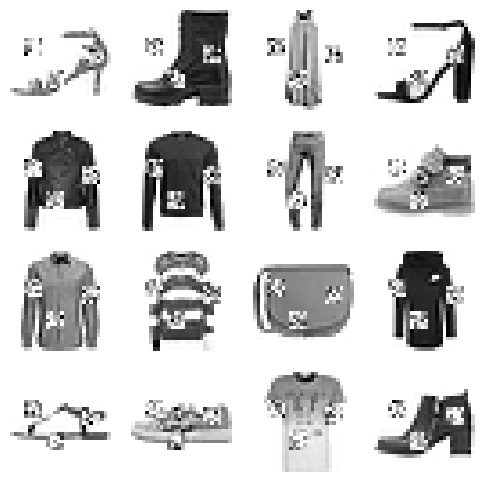

In [59]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [60]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [61]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

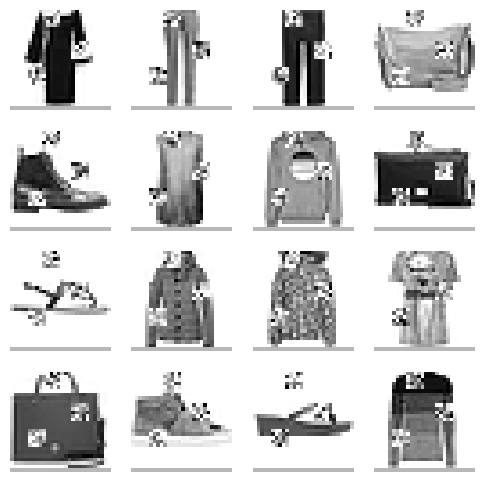

In [62]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train
0.762,0.876,0,train
0.830,0.573,0,eval
0.844,0.623,1,train
0.843,0.523,1,eval
0.865,0.530,2,train
0.859,0.481,2,eval
0.870,0.466,3,train
0.874,0.400,3,eval
0.879,0.406,4,train
0.866,0.419,4,eval


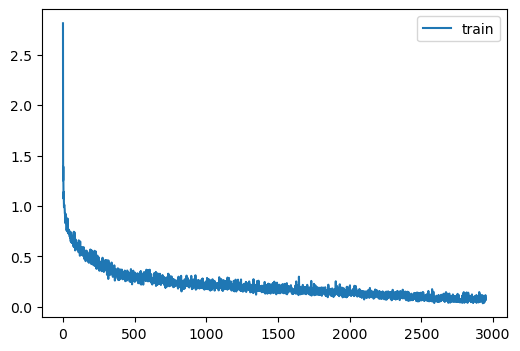

In [63]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
torch.save(learn.model, mdl_path/'model_rand_erase.pkl')

accuracy,loss,epoch,train
0.757,0.895,0,train
0.799,0.652,0,eval
0.843,0.629,1,train
0.859,0.503,1,eval
0.861,0.540,2,train
0.873,0.436,2,eval
0.867,0.483,3,train
0.869,0.417,3,eval
0.881,0.402,4,train
0.839,0.498,4,eval


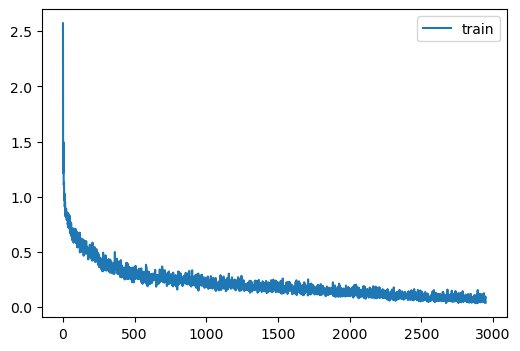

In [81]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model0(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [82]:
torch.save(learn.model, mdl_path/'model0_50ep_rand_erase.pkl')

### Random copy

In [83]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [84]:
pct = 0.2

In [68]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1,sty1,stx2,sty2,szx,szy

(3, 9, 22, 16, 5, 5)

In [69]:
xbt[:,:,stx1:stx1+szx,sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

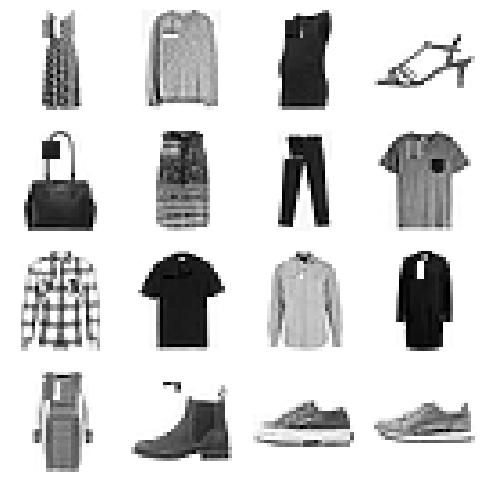

In [70]:
show_images(xbt, imsize=1.5)

In [71]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

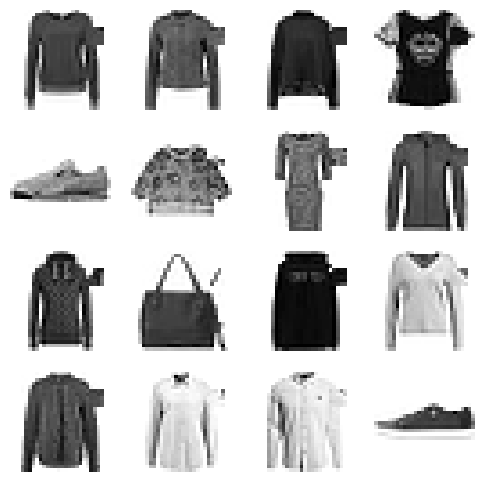

In [72]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

In [85]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

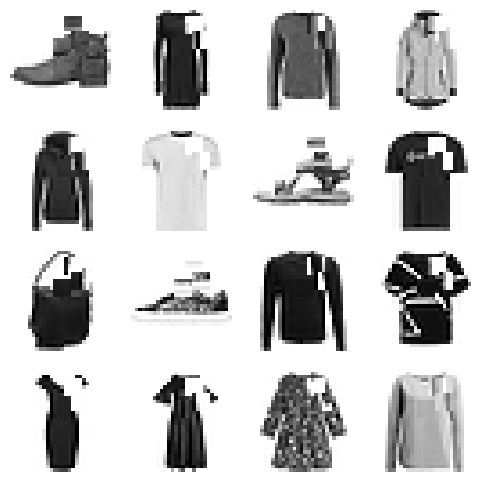

In [86]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [87]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [88]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

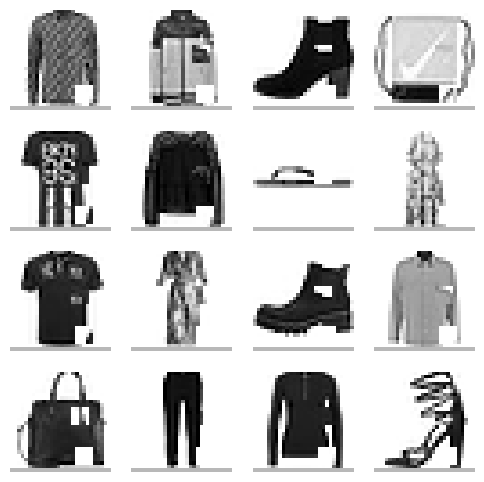

In [90]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

Let's do 25 epochs so we can combine this model with another one trained for 25 epochs and see if we can beat a 50 epoch model.

accuracy,loss,epoch,train
0.728,0.974,0,train
0.808,0.635,0,eval
0.834,0.665,1,train
0.845,0.540,1,eval
0.856,0.549,2,train
0.869,0.455,2,eval
0.866,0.467,3,train
0.870,0.413,3,eval
0.878,0.398,4,train
0.878,0.349,4,eval


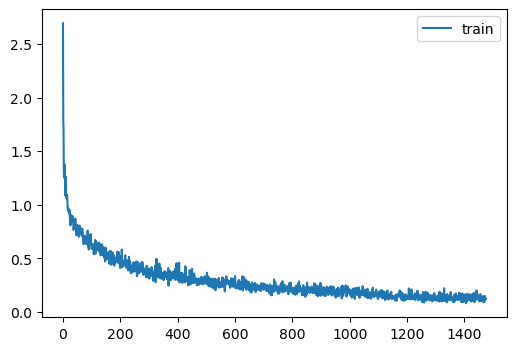

In [94]:
set_seed(1)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model0(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

### Ensembling - two models

accuracy,loss,epoch,train
0.728,0.974,0,train
0.807,0.636,0,eval
0.834,0.664,1,train
0.843,0.543,1,eval
0.856,0.550,2,train
0.873,0.445,2,eval
0.868,0.465,3,train
0.866,0.417,3,eval
0.876,0.402,4,train
0.873,0.372,4,eval


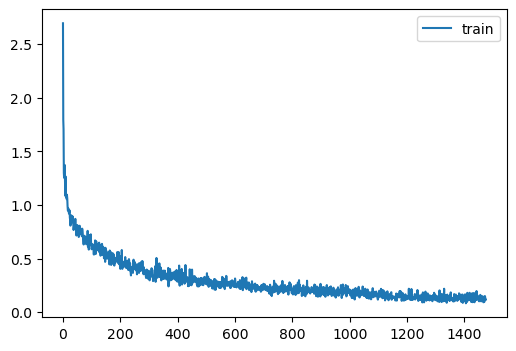

In [95]:
set_seed(1)
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

In [96]:
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

In [98]:
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=[cp1])

accuracy,loss,epoch,train
0.944,0.164,0,eval


In [99]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=[cp2])

accuracy,loss,epoch,train
0.945,0.164,0,eval


In [102]:
ap1 = torch.cat(cp1.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp.all_targs)

In [128]:
ap = torch.stack([cp1.all_preds,cp2.all_preds]).mean(0).argmax(1)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [104]:
round((ap==cp1.all_targs).float().mean().item(), 3)

0.945

### Dropout

In [129]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 0.])

In [130]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [131]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [135]:
def get_dropmodel0(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=3, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [132]:
set_seed(1)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.814,0.736,0,train
0.872,0.421,0,eval
0.892,0.397,1,train
0.883,0.366,1,eval
0.918,0.274,2,train
0.917,0.261,2,eval
0.940,0.202,3,train
0.924,0.235,3,eval
0.958,0.151,4,train
0.930,0.222,4,eval


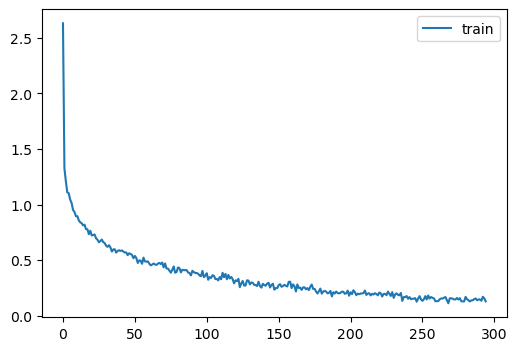

In [133]:
learn.fit(epochs)

The accuracy after 5 epochs with and without dropout are similar. Let's try with model0 (first kernel is `3x3` instead of `5x5`).

In [136]:
set_seed(1)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel0(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.800,0.770,0,train
0.843,0.519,0,eval
0.895,0.389,1,train
0.883,0.367,1,eval
0.919,0.274,2,train
0.903,0.305,2,eval
0.941,0.199,3,train
0.924,0.239,3,eval
0.959,0.147,4,train
0.933,0.218,4,eval


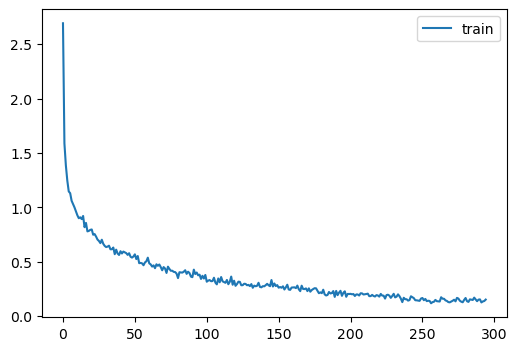

In [137]:
learn.fit(epochs)

In [134]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m: m.train() if isinstance(m, (nn.Dropout,nn.Dropout2d)) else None)

Quick implemenation of Dropout2d:

In [97]:
# m = Binomial(100, torch.tensor([0 , .2, .8, 1]))
# x = m.sample()

m = distributions.binomial.Binomial(torch.tensor([1.]), torch.tensor(0.8))
x = m.sample(torch.Size([3]))

In [98]:
x.shape

torch.Size([3, 1])

In [99]:
x_ = x.reshape(1,-1,1,1)
x_.shape

torch.Size([1, 3, 1, 1])

In [101]:
x_

tensor([[[[1.]],

         [[1.]],

         [[0.]]]])

In [43]:
u = torch.rand(2,3,2,2)
u.shape

torch.Size([2, 3, 2, 2])

In [100]:
x_*u

tensor([[[[0.13, 0.27],
          [0.71, 0.49]],

         [[0.61, 0.05],
          [0.30, 0.49]],

         [[0.00, 0.00],
          [0.00, 0.00]]],


        [[[0.28, 0.72],
          [0.94, 0.91]],

         [[0.39, 0.48],
          [0.48, 0.79]],

         [[0.00, 0.00],
          [0.00, 0.00]]]])

In [275]:
class Dropout2d(nn.Module):
    def __init__(self, drop=0.8):
        super().__init__()
        self.drop = drop
    
    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.drop)
        return dist.sample(torch.Size([x.shape[1]])).reshape(1,-1,1,1)*x 

In [266]:
v = Dropout2d(0.1)

In [267]:
print(v(u))

tensor([[[[0.13, 0.27],
          [0.71, 0.49]],

         [[0.61, 0.05],
          [0.30, 0.49]],

         [[0.91, 0.13],
          [0.61, 0.56]]],


        [[[0.28, 0.72],
          [0.94, 0.91]],

         [[0.39, 0.48],
          [0.48, 0.79]],

         [[0.23, 0.62],
          [0.79, 0.79]]]])


In [268]:
u

tensor([[[[0.13, 0.27],
          [0.71, 0.49]],

         [[0.61, 0.05],
          [0.30, 0.49]],

         [[0.91, 0.13],
          [0.61, 0.56]]],


        [[[0.28, 0.72],
          [0.94, 0.91]],

         [[0.39, 0.48],
          [0.48, 0.79]],

         [[0.23, 0.62],
          [0.79, 0.79]]]])

In [269]:
m = nn.Sequential(Dropout2d(0.9),nn.Conv2d(3,3, kernel_size=1, stride=1))

In [270]:
m[0].drop=0.8

In [271]:
m(u)

tensor([[[[-0.05, -0.05],
          [-0.05, -0.05]],

         [[ 0.08,  0.08],
          [ 0.08,  0.08]],

         [[-0.00, -0.00],
          [-0.00, -0.00]]],


        [[[-0.05, -0.05],
          [-0.05, -0.05]],

         [[ 0.08,  0.08],
          [ 0.08,  0.08]],

         [[-0.00, -0.00],
          [-0.00, -0.00]]]], grad_fn=<ConvolutionBackward0>)

In [25]:
dis = distributions.binomial.Binomial(tensor(1.0), probs=0.5)

In [46]:
distributions.binomial.Binomial(tensor(1.0), probs=0.9).sample(u.shape)

tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 0.],
          [1., 1.]],

         [[1., 1.],
          [1., 0.]]],


        [[[1., 1.],
          [1., 0.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]])

In [363]:
def get_model_Drop2d(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(1, 16, ks=3, stride=1, act=act, norm=norm), Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [380]:
res = []
def check_dropout(m, inps, outs):
    res.append(outs.to('cpu').sum((-2,-1)))

In [381]:
m = get_model_Drop2d(act_gr, norm=nn.BatchNorm2d).apply(iw)
h = m[1].register_forward_hook(check_dropout)

In [382]:
lr = 1e-2
learn = TrainLearner(m, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB()], opt_func=optim.AdamW)

In [383]:
learn.fit(1)

It works normally, the dropped out channels have all zeros, hence their sum on the H, W dimensions (in NCHW) is 0.

In [385]:
res[0].shape, res[0][1]

(torch.Size([1024, 16]),
 tensor([  31.34, 1369.97,  102.38, -110.89,  141.14,    0.00, -333.69,   50.88, -187.93, -254.77, -302.80, -245.76,    0.00,    0.00,
         -130.90, -159.06], grad_fn=<SelectBackward0>))

### Export

In [138]:
import nbdev; nbdev.nbdev_export()